In [1]:
# Some basic imports and setup
import numpy as np
import numpy.random as nr
import gym
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import time
from ipywidgets import FloatProgress
from IPython.display import display
np.set_printoptions(precision=3)
from robolearn.envs.simple_envs.cliff import CliffEnv
# from robolearn.utils.general.notebook_utils import log_progress

ModuleNotFoundError: No module named 'robolearn.envs.cliff'

### Q learning update
After we observe a transition $s, a, s', r$:

$$\textrm{target}(s') = R(s,a,s') + \gamma \max_{a'} Q_{\theta_k}(s',a')$$


$$Q_{k+1}(s,a) \leftarrow (1-\alpha) Q_k(s,a) + \alpha \left[ \textrm{target}(s') \right]$$

In [2]:
# Common parameters
nRuns = 10
nIt = 500
H = 100
gamma = 1.0  # Discount factor
alpha = 0.5  # Learning rate
eps = 0.1  # eps in eps_greedy
eps_decrease = False
temp_decrease = True
min_temp = 2
default_temp = 5*min_temp

seeds = np.arange(nRuns, dtype=np.uint8)
eps_decrement = eps / nIt



# Environment
env = CliffEnv(map_name='4x12', is_slippery=True, reward_dict={'G':1, 'S':-0.00, 'H':-1.00, 'F':0.00})

In [3]:
def learning_process(agent, **kwargs):
    # Initial q_vals. All zeros
    run_q_vals = [None for _ in range(nRuns)]  # Save the final q_val for each run
    rets = np.zeros((nRuns, nIt))
    tfailures = np.zeros(nRuns)
    
    temp = kwargs.pop('temp')
    
    if isinstance(temp, tuple):
        temp_decrement = tuple(((temp[0]-min_temp)/nIt, (temp[1]-min_temp)/nIt))
    else:
        temp_decrement = (temp-min_temp) / nIt  # Assuming minimum temperature is 0.05
#     print(temp_decrement)
    
    # Learning
    for rr in range(nRuns):
        random.seed(int(seeds[rr]))  # Set seed for action selection
        np.random.seed(int(seeds[rr]))
        env.seed(int(seeds[rr]))


        total_failures = 0
        agent.reset_q_vals()
        train_eps = eps
        
        for itr in range(nIt):
            obs = env.reset()
            done = False
            ret = 0.  # Return
            
            if isinstance(temp, tuple):
                train_temp = tuple((temp[0]-itr*temp_decrement[0], temp[1]-itr*temp_decrement[1]))
            else:
                train_temp = temp - itr*temp_decrement

            for t in range(H):
#                 print(rr, itr, t, train_temp)
                action = agent.act(obs, policy='softmax', temp=train_temp, **kwargs)
                
                next_obs, reward, done, info = env.step(action)
                ret += reward

                agent.q_learning_update(gamma, alpha, obs, action, next_obs, reward, failure=(obs != env.nS - 1))

                obs = next_obs
                rets[rr, itr] = ret
                if done:
                    if obs != env.nS - 1:
                        total_failures += 1
                    break
                    
#         run_q_vals[rr] = agent.q_vals.copy()

        tfailures[rr] = total_failures
        print('The percentage of failures for run %d is: %f' % (rr, total_failures / nIt))
        print('The average return for run %d is: %f' % (rr, rets[rr, :].mean()))
        print('--')
        
    return rets, tfailures

# Normal Agent

In [4]:
class QAgent(object):

    def __init__(self, n_state, n_act):
        self.nS = n_state
        self.nA = n_act
        self.q_vals = np.zeros((env.observation_space.n, env.action_space.n))
        
    def act(self, state, policy='greedy', **kwargs):
        if policy.lower() == 'greedy':
            policy = self.greedy
        elif policy.lower() == 'eps_greedy':
            policy = self.eps_greedy
        elif policy.lower() == 'softmax':
            policy = self.softmax
        else:
            raise ValueError('Wrong policy option "%s"' % policy)
        
        return policy(state, **kwargs)
    
    def greedy(self, state, **kwargs):
        return np.argmax(self.q_vals[state])
        
    def eps_greedy(self, state, eps=0.2, **kwargs):
        random_num = random.random()
        if random_num < eps:
            # Explorate action space
            act = random.randrange(len(self.q_vals[state]))
        else:
            # Greedy action
            act = self.greedy(state)
        return act

    def softmax(self, state, temp=0.2, **kwargs):
        policy = self.softmax_policy(self.q_vals[state],temp)
        return np.random.choice(np.arange(len(self.q_vals[state])), p=policy)
    
    def reset_q_vals(self):
        self.q_vals = np.zeros_like(self.q_vals)
    
    def q_learning_update(self, gamma, alpha, cur_state, action, next_state, reward, **kwargs):
        """
        Inputs:
            gamma: discount factor
            alpha: learning rate
            cur_state: current state
            action: action taken in current state
            next_state: next state results from taking `action` in `cur_state`
            reward: reward received from this transition

        Performs in-place update of q_vals table to implement one step of Q-learning
        """
#         print('cur_state', cur_state, 'next_state', next_state)
        target = reward + gamma * np.max(self.q_vals[next_state])
        self.q_vals[cur_state][action] = (1-alpha)*self.q_vals[cur_state][action] + alpha*target
        
    def softmax_policy(self, q_vals, temp):
        return np.exp(q_vals/temp)/np.exp(q_vals/temp).sum()

In [5]:
# Agent
normal_agent = QAgent(env.nS, env.nA)
temp = default_temp  # temp in soft_policy | higher, actions equally probable [0,2] ??

rets_normal, tfailures_normal = learning_process(normal_agent, temp=temp)

The percentage of failures for run 0 is: 0.174000
The average return for run 0 is: -102.526000
--
The percentage of failures for run 1 is: 0.156000
The average return for run 1 is: -99.550000
--
The percentage of failures for run 2 is: 0.150000
The average return for run 2 is: -100.798000
--
The percentage of failures for run 3 is: 0.164000
The average return for run 3 is: -101.444000
--
The percentage of failures for run 4 is: 0.156000
The average return for run 4 is: -102.590000
--
The percentage of failures for run 5 is: 0.142000
The average return for run 5 is: -100.578000
--
The percentage of failures for run 6 is: 0.172000
The average return for run 6 is: -101.358000
--
The percentage of failures for run 7 is: 0.162000
The average return for run 7 is: -100.972000
--
The percentage of failures for run 8 is: 0.178000
The average return for run 8 is: -101.308000
--
The percentage of failures for run 9 is: 0.196000
The average return for run 9 is: -102.426000
--


# YinYang Agent

In [6]:
class YinYangQAgent(object):
    def __init__(self, n_state, n_act, w_q_bad=2):
        self.agent1 = QAgent(n_state, n_act)
        self.agent2 = QAgent(n_state, n_act)
        
        self.w_q_bad = w_q_bad

    def act(self, state, policy='greedy', **kwargs):
        if policy.lower() == 'greedy':
            raise NotImplementedError
#             policy = self.greedy
        elif policy.lower() == 'eps_greedy':
            raise NotImplementedError
#             policy = self.eps_greedy
        elif policy.lower() == 'softmax':
            policy = self.softmax
        else:
            raise ValueError('Wrong policy option "%s"' % policy)
        
        return policy(state, **kwargs)
        
    def reset_q_vals(self):
        self.agent1.reset_q_vals()
        self.agent2.reset_q_vals()
        
    def q_learning_update(self, gamma, alpha, cur_state, action, next_state, reward, failure=False):
        self.agent1.q_learning_update(gamma, alpha, cur_state, action, next_state, reward)
        if failure:
            self.agent2.q_learning_update(gamma, alpha, cur_state, action, next_state, self.w_q_bad*reward)
        else:
            self.agent2.q_learning_update(gamma, alpha, cur_state, action, next_state, reward)
            
    def softmax(self, state, temp=(0.2), w1=0.5, w2=0.5):
        if isinstance(temp, tuple):
            temp1 = temp[0]
            temp2 = temp[1]
        else:
            temp1 = temp2 = temp
        
#         policy1 = np.exp(self.agent1.q_vals[state]/temp1)/np.exp(self.agent1.q_vals[state]/temp1).sum()
#         policy2 = np.exp(self.agent2.q_vals[state]/temp2)/np.exp(self.agent2.q_vals[state]/temp2).sum()
        policy1 = self.softmax_policy(self.agent1.q_vals[state], temp1)
        policy2 = self.softmax_policy(self.agent2.q_vals[state], temp2)
        
#         if w1 + w2 != 1:
#             raise ('w1 and w2 should sum 1!!')
        
        behavioral_policy = (w1*policy1 + w2*policy2)/(w1+w2)
        
        return np.random.choice(np.arange(len(self.agent1.q_vals[state])), p=behavioral_policy)
    
    def softmax_policy(self, q_vals, temp):
        return np.exp(q_vals/temp)/np.exp(q_vals/temp).sum()

In [7]:
# Learning Process
wGood = 0.5
wBad = 0.5
w_q_bad = 1
temp = (default_temp, min_temp)

# Agent
yy_agent = YinYangQAgent(env.nS, env.nA, w_q_bad=w_q_bad)
rets_yy, tfailures_yy = learning_process(yy_agent, w1=wGood, w2=wBad, temp=temp)

The percentage of failures for run 0 is: 0.126000
The average return for run 0 is: -94.756000
--
The percentage of failures for run 1 is: 0.134000
The average return for run 1 is: -94.152000
--
The percentage of failures for run 2 is: 0.118000
The average return for run 2 is: -93.484000
--
The percentage of failures for run 3 is: 0.142000
The average return for run 3 is: -93.664000
--
The percentage of failures for run 4 is: 0.136000
The average return for run 4 is: -94.590000
--
The percentage of failures for run 5 is: 0.104000
The average return for run 5 is: -93.298000
--
The percentage of failures for run 6 is: 0.126000
The average return for run 6 is: -94.798000
--
The percentage of failures for run 7 is: 0.116000
The average return for run 7 is: -93.950000
--
The percentage of failures for run 8 is: 0.164000
The average return for run 8 is: -95.218000
--
The percentage of failures for run 9 is: 0.156000
The average return for run 9 is: -94.474000
--


# Comparaisons

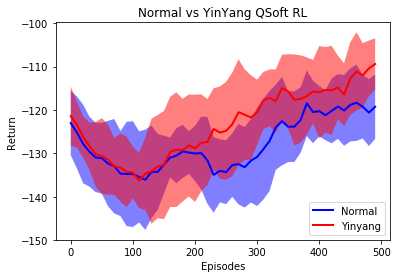

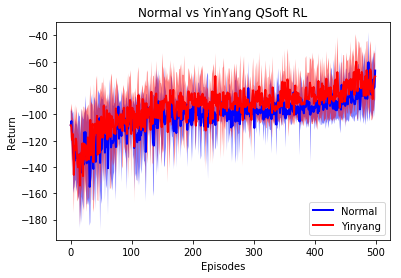

***************
Normal Failures  || Avg: 0.016500 | Max: 0.019600 | Min: 0.014200
YinYang Failures || Avg: 0.013220 | Max: 0.016400 | Min: 0.010400


In [8]:
%matplotlib inline

# Avg_return
plot_jump = 10

n_data = int(np.around(nIt/plot_jump))
t = np.arange(0, n_data)*plot_jump
data1 = np.zeros((nRuns, n_data))
data2 = np.zeros((nRuns, n_data))
for nn in range(n_data):
    data1[:, nn] = rets_normal[:, nn:nn+plot_jump].mean(axis=1)
    data2[:, nn] = rets_yy[:, nn:nn+plot_jump].mean(axis=1)

mus1 = data1.mean(axis=0)
sigmas1 = data1.std(axis=0)
mus2 = data2.mean(axis=0)
sigmas2 = data2.std(axis=0)
fig, ax = plt.subplots(1, 1)
ax.plot(t, mus1, lw=2, label='Normal', color='blue')
ax.plot(t, mus2, lw=2, label='Yinyang', color='red')
ax.fill_between(t, mus1+sigmas1, mus1-sigmas1, facecolor='blue', alpha=0.5)
ax.fill_between(t, mus2+sigmas2, mus2-sigmas2, facecolor='red', alpha=0.5)
ax.set_title('Normal vs YinYang QSoft RL')
ax.legend(loc='lower right')
ax.set_xlabel('Episodes')
ax.set_ylabel('Return')

plot_jump = 1
n_data = int(np.around(nIt/plot_jump))
t = np.arange(0, n_data)*plot_jump
data1 = np.zeros((nRuns, n_data))
data2 = np.zeros((nRuns, n_data))
for nn in range(n_data):
    data1[:, nn] = rets_normal[:, nn:nn+plot_jump].mean(axis=1)
    data2[:, nn] = rets_yy[:, nn:nn+plot_jump].mean(axis=1)

mus1 = data1.mean(axis=0)
sigmas1 = data1.std(axis=0)
mus2 = data2.mean(axis=0)
sigmas2 = data2.std(axis=0)
fig, ax = plt.subplots(1, 1)
ax.plot(t, mus1, lw=2, label='Normal', color='blue')
ax.plot(t, mus2, lw=2, label='Yinyang', color='red')
ax.fill_between(t, mus1+sigmas1, mus1-sigmas1, facecolor='blue', alpha=0.5)
ax.fill_between(t, mus2+sigmas2, mus2-sigmas2, facecolor='red', alpha=0.5)
ax.set_title('Normal vs YinYang QSoft RL')
ax.legend(loc='lower right')
ax.set_xlabel('Episodes')
ax.set_ylabel('Return')

plt.show()


# Failures
print('*'*15)
print('Normal Failures  || Avg: %f | Max: %f | Min: %f' % (tfailures_normal.mean()/(nRuns*nIt),
                                                           tfailures_normal.max()/(nRuns*nIt),
                                                           tfailures_normal.min()/(nRuns*nIt)))
print('YinYang Failures || Avg: %f | Max: %f | Min: %f' % (tfailures_yy.mean()/(nRuns*nIt),
                                                           tfailures_yy.max()/(nRuns*nIt),
                                                           tfailures_yy.min()/(nRuns*nIt)))


# Hyperparameter Compairison

In [9]:
# Learning Process
wGood = 0.5
wBad = 0.5
w_q_bad = 1
temp = (default_temp, min_temp)

wGood = np.arange(0, 1.1, 0.1)
wBad = 1 - wGood

n_agents = len(wGood)

w_yy_agents = [None for _ in range(n_agents)]
w_rets_yy = [None for _ in range(n_agents)]
w_tfailures_yy = [None for _ in range(n_agents)]


# Agent
for tt in range(n_agents):
    print('%'*15)
    print('%'*15)
    print('Training YY agent %d' % tt)
    w_yy_agents[tt] = YinYangQAgent(env.nS, env.nA, w_q_bad=w_q_bad)
    w_rets_yy[tt], w_tfailures_yy[tt] = learning_process(w_yy_agents[tt], w1=wGood[tt], w2=wBad[tt], temp=temp)

%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%
Training YY agent 0
The percentage of failures for run 0 is: 0.078000
The average return for run 0 is: -83.572000
--
The percentage of failures for run 1 is: 0.072000
The average return for run 1 is: -81.856000
--
The percentage of failures for run 2 is: 0.072000
The average return for run 2 is: -82.600000
--
The percentage of failures for run 3 is: 0.086000
The average return for run 3 is: -83.026000
--
The percentage of failures for run 4 is: 0.072000
The average return for run 4 is: -84.262000
--
The percentage of failures for run 5 is: 0.080000
The average return for run 5 is: -82.716000
--
The percentage of failures for run 6 is: 0.078000
The average return for run 6 is: -81.736000
--
The percentage of failures for run 7 is: 0.072000
The average return for run 7 is: -82.142000
--
The percentage of failures for run 8 is: 0.072000
The average return for run 8 is: -81.692000
--
The percentage of failures for run 9 is: 0.074000
The average return for ru

The percentage of failures for run 0 is: 0.176000
The average return for run 0 is: -99.796000
--
The percentage of failures for run 1 is: 0.154000
The average return for run 1 is: -97.918000
--
The percentage of failures for run 2 is: 0.152000
The average return for run 2 is: -99.260000
--
The percentage of failures for run 3 is: 0.168000
The average return for run 3 is: -98.142000
--
The percentage of failures for run 4 is: 0.154000
The average return for run 4 is: -99.742000
--
The percentage of failures for run 5 is: 0.156000
The average return for run 5 is: -99.522000
--
The percentage of failures for run 6 is: 0.150000
The average return for run 6 is: -98.938000
--
The percentage of failures for run 7 is: 0.170000
The average return for run 7 is: -99.100000
--
The percentage of failures for run 8 is: 0.130000
The average return for run 8 is: -98.360000
--
The percentage of failures for run 9 is: 0.186000
The average return for run 9 is: -98.594000
--
%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%

In [10]:
for tt in range(n_agents):
    print('YinYang %.2f Failures || Avg: %f | Max: %f | Min: %f' % (wGood[tt],
                                                                    w_tfailures_yy[tt].mean()/(nRuns*nIt),
                                                                    w_tfailures_yy[tt].max()/(nRuns*nIt),
                                                                    w_tfailures_yy[tt].min()/(nRuns*nIt)))

YinYang 0.00 Failures || Avg: 0.007560 | Max: 0.008600 | Min: 0.007200
YinYang 0.10 Failures || Avg: 0.009240 | Max: 0.010400 | Min: 0.008400
YinYang 0.20 Failures || Avg: 0.009940 | Max: 0.011000 | Min: 0.009200
YinYang 0.30 Failures || Avg: 0.011200 | Max: 0.012200 | Min: 0.010200
YinYang 0.40 Failures || Avg: 0.012320 | Max: 0.013400 | Min: 0.011200
YinYang 0.50 Failures || Avg: 0.013220 | Max: 0.016400 | Min: 0.010400
YinYang 0.60 Failures || Avg: 0.015080 | Max: 0.020200 | Min: 0.013200
YinYang 0.70 Failures || Avg: 0.014920 | Max: 0.016200 | Min: 0.012400
YinYang 0.80 Failures || Avg: 0.015960 | Max: 0.018600 | Min: 0.013000
YinYang 0.90 Failures || Avg: 0.016660 | Max: 0.017600 | Min: 0.015800
YinYang 1.00 Failures || Avg: 0.016500 | Max: 0.019600 | Min: 0.014200


In [11]:
# # Print current q_vals
# for q_val in range(q_vals.shape[0]):
# #     print(q_val, ': ', q_vals[q_val])
#     print(q_val, ': ', agent.q_vals[q_val])

# Visualize Final policies

In [12]:
def visualize_policy(agent, temp):
    %matplotlib notebook
    
    env.seed(21); from gym.spaces import prng; prng.seed(25)
    random.seed(11)  # Set seed for action selection
    np.random.seed(10)

    # Notebook figure
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    # Generate the episode
    ob = env.reset()
    render = ax.imshow(env.render(mode='rgb_array'))
    ret = 0
    H = 100
    for t in range(H):
        fig.canvas.set_window_title('Frozen Lake -- Iteration: %02d' % t)
        time.sleep(0.2)
        render.set_data(env.render(mode='rgb_array'))
        fig.canvas.draw()
        a = agent.act(ob, policy='softmax', temp=temp)
        ob, rew, done, _ = env.step(a)
        ret += rew
        print('iter', t, '| ob',ob, '| action',a, '| reward',rew)
        if done:
            break
    assert done
    fig.canvas.set_window_title('Frozen Lake -- Iteration: %02d' % t)
    time.sleep(0.5)
    render.set_data(env.render(mode='rgb_array'))
    fig.canvas.draw()
    # env.render(close=True)
    print('Finished at t=%d'%(t+1),'| Acum reward:', ret)

In [13]:
def plot_policy(Qs):
#     %matplotlib inline
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    ax.imshow(Qs.max(axis=1).reshape(4, 12), cmap='gray', interpolation='none', clim=(Qs.max(axis=1).min(), Qs.max(axis=1).max()))
    ax.set_xticks(np.arange(12)-.5)
    ax.set_yticks(np.arange(4)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(-1, 0)}
#     Pi = pi.reshape(4,4)
    for y in range(4):
        for x in range(12):
#             a = Pi[y, x]
            a = Qs.argmax(axis=1).reshape(4, 12)[y, x]
            u, v = a2uv[a]
            if Qs.max(axis=1).reshape(4, 12)[y, x] == 0:
                color='r'
            else:
                color='g'
            plt.arrow(x, y,u*.3, -v*.3, color=color, head_width=0.1, head_length=0.1) 
            plt.text(x, y, str(env.desc[y,x].item().decode()),
                     color='b', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    plt.grid(color='b', lw=2, ls='-')

In [14]:
# Common stuff

# Seed RNGs
# env = CliffEnv(map_name='4x12', is_slippery=True, reward_dict={'G':1, 'S':-0.00, 'H':-1.00, 'F':0.00})


<IPython.core.display.Javascript object>


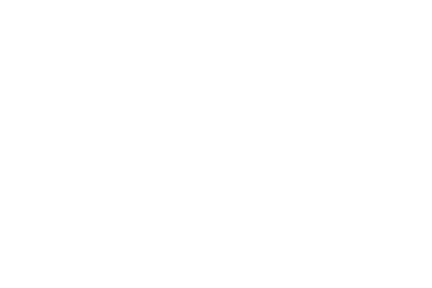

NotImplementedError: 

<IPython.core.display.Javascript object>


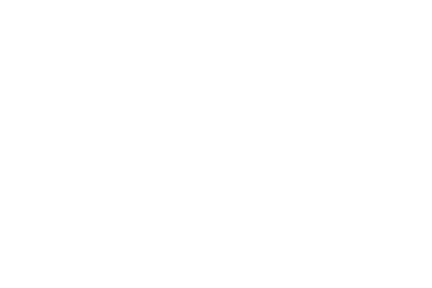

In [15]:
# Normal Agent
visualize_policy(normal_agent, min_temp)

In [ ]:
# Yin Yang Agent
# visualize_policy(yy_agent, min_temp)
visualize_policy(w_yy_agents[-1], min_temp)

In [ ]:
yy = YinYangQAgent(env.nS, env.nA, w_q_bad=w_q_bad)

n_yy = 5

test_yy = w_yy_agents[n_yy]

q_vals1 = test_yy.agent1.q_vals
q_vals2 = test_yy.agent2.q_vals

state = 36

print(q_vals1[state])
print(q_vals2[state])

print(yy.softmax_policy(q_vals1[state], 10))
print(yy.softmax_policy(q_vals1[state], 50))
# tfailures_normal
# nRuns

In [ ]:
plot_policy(normal_agent.q_vals)

for aa, agent in enumerate(w_yy_agents):
    plot_policy(agent.agent1.q_vals)
    plt.title('YY'+str(aa))
